# Ordinary Differential Equations

In [76]:
import numpy as np
import jax.numpy as jnp
%matplotlib inline
import matplotlib.pyplot as plt


## Dynamics of ideal pendulum

We want to predict how the angle of a pendulum, $u$ changes as a function of time subject to gravity.
The dynamical system can be characterized by two states: 
* u : the position
* du : the velocity

Note that the states of a system do not have to be derivatives of each other, it just happens to be the case for many dynamical systems describing physical phenomena.

(-1.0, 1.0)

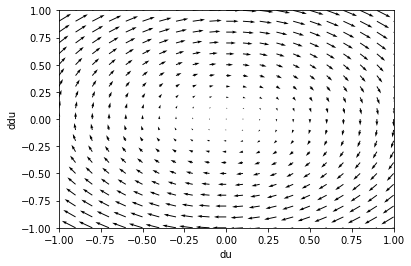

In [77]:
m = 1.0 # mass
g = 1.0 # gravity

x_min = -1.0
x_max = 1.0
y_min = -1.0
y_max = 1.0
dx = 0.1
dy = 0.1

def f(t,y):
    u, du = y
    ddu = -(g/m)*np.sin(u)
    return du, ddu

x, y = np.meshgrid(np.arange(x_min,x_max+dx,dx), np.arange(y_min, y_max+dy,dy))
du,ddu = f(None,(x,y))

fig, ax = plt.subplots()
plt.quiver(x,y,du,ddu, scale_units="xy",angles="xy")
plt.xlabel("du")
plt.ylabel("ddu")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

## Obtaining a trajectory

### Implementing Forward Euler

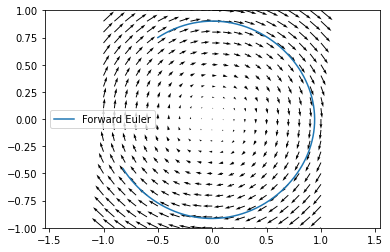

In [83]:
t_start = 0.0
t_end = 5.0
dt = 0.01
t_eval = np.arange(t_start, t_end+dt ,dt)
y0 = (-0.5, 0.75)

def solve_forward_euler(t_start, t_end, dt, y0):
    y0 = np.array(y0)
    t_eval = t_eval = np.arange(t_start, t_end+dt ,dt)
    y = y0
    ys = [y0]
    for t in t_eval[:-1]:
        dy = np.array(f(t,y))
        y = y + dt*dy
        ys.append(y)
    
    return np.stack(ys,axis=1)

u_fe, du_fe = solve_forward_euler(t_start,t_end,dt,y0)
fig, ax = plt.subplots()
ax.quiver(x,y,du,ddu)
ax.plot(u_fe,du_fe, label="Forward Euler")
ax.axis("equal")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.legend()

### Using third-party solver

(-1.0, 1.0)

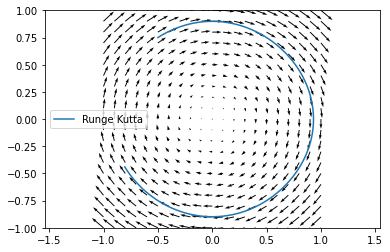

In [81]:
from scipy.integrate import solve_ivp

u_rk45, du_rk45 = solve_ivp(f, (t_start,t_end), y0, "RK45", t_eval).y

fig, ax = plt.subplots()
ax.quiver(x,y,du,ddu)
ax.plot(u_rk45,du_rk45, label="Runge Kutta")
ax.axis("equal")
ax.legend()
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

## Learning dynamics from data

In [69]:
from jax.experimental.stax import serial, Dense, Softplus
from jax import random
from jax import vmap
import jax.numpy as jnp
from tqdm import tqdm

key = random.PRNGKey(0) # every random operation in jax is seeded

## Partially known dynamics
Suppose we know the shape of the derivative function, but only have rough estimates of the coefficients?

(-1.0, 1.0)

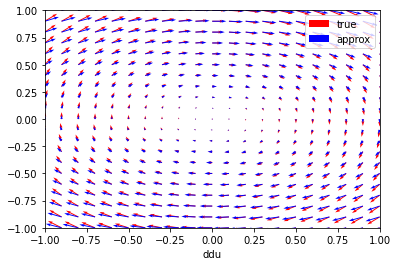

In [70]:
m_true = 1.0
m_approx = 2.0
g = 1.0

def f(u, du, m):
    ddu = - g/m * jnp.sin(u)
    return du, ddu

x, y = np.meshgrid(np.arange(x_min,x_max+dx,dx), np.arange(y_min, y_max+dy,dy))
du_approx, ddu_approx = f(x, y, m_approx)
du_true, ddu_true = f(x, y, m_true)

fig, ax = plt.subplots()
ax.quiver(x,y,du_true,ddu_true, scale_units="xy",angles="xy", label="true", color="red")
ax.quiver(x,y,du_approx,ddu_approx, scale_units="xy",angles="xy", label="approx", color="blue")
ax.legend()
ax.set_xlabel("du")
ax.set_xlabel("ddu")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

Is it possible to tune optimize the choice of $\hat{m}$ such that the dynamics of the true system are approximated well?

Two scenarios are:
1. We know ground truth derivatives, $du, ddu$
2. We know ground solutions trajectories $du(t), ddu(t)$ and use these to infer $du, ddu$ that lead to correct trajectories

In both cases we:
1. Define a loss function that measures the error in predictions for the models parameters, $\theta$
2. Obtain sensitivity of loss on models parameters $\frac{dL}{d\theta}(\theta)$
3. Update parameters to minimize loss

We use [JAX](https://jax.readthedocs.io/en/latest/) to implement the optimization loop.

training: 100%|██████████| 60/60 [00:00<00:00, 389.37it/s]


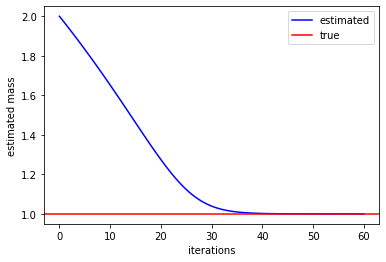

In [71]:
from jax import value_and_grad
from jax import jit

m_approx = 2.0
learning_rate = 0.001

def loss(m):
    du, ddu = f(x,y,m)
    return jnp.sum((du-du_true)**2 + (ddu-ddu_true)**2)

#@jit
def update(m):
    value, grad = value_and_grad(loss, argnums=0)(m)
    m = m - learning_rate * grad
    return m


ms = [m_approx]
for i in tqdm(range(60),desc="training"):
    
    m_approx = update(m_approx)
    ms.append(m_approx)

fig, ax = plt.subplots()
ax.plot(ms,label="estimated",c="blue")
ax.set_xlabel("iterations")
ax.set_ylabel("estimated mass")
ax.axhline(m_true,label="true",c="red")
ax.legend()

value of m estimated to 1.0000056028366089, true value is 1.0


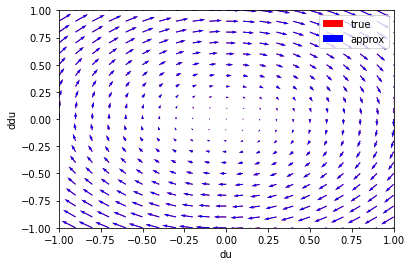

In [72]:
du_approx, ddu_approx = f(x, y, m_approx)
du_true, ddu_true = f(x, y, m_true)

fig, ax = plt.subplots()
ax.quiver(x,y,du_true,ddu_true, scale_units="xy",angles="xy", label="true", color="red")
ax.quiver(x,y,du_approx,ddu_approx, scale_units="xy",angles="xy", label="approx", color="blue")
ax.legend()
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.set_xlabel("du")
ax.set_ylabel("ddu")

print(f"value of m estimated to {m_approx}, true value is {m_true}")

Alternatively, if we only have the solutions for dynamical system, we can use those to infer the parameters of the dynamics that result in the solution we have observed.
The process for tuning based on this is:
1. take an initial guess on m
2. simulate the system for initial conditions corresponding to those of the ground truth
3. calculate the difference between the solution produced by the approximate m and the ground truth
4. update m such that the difference is minimized
5. repeat 2-4

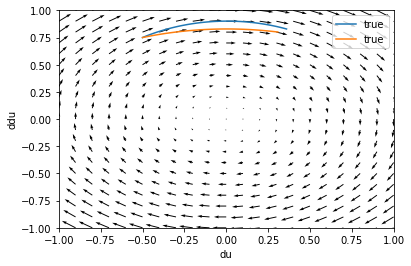

In [73]:
m_approx = 2.0
dt = 0.01
t_eval = jnp.arange(0.0, 1.0+dt, dt)


def simulate(u,du,m):
    
    U = [u]
    dU = [du]

    for _ in t_eval[:-1]:
        du, ddu = f(u,du,m)
        u = u + dt*du
        du = du + dt*ddu
        U.append(u)
        dU.append(du)

    return U, dU

u_true, du_true = simulate(*y0,m_true)
u_approx, du_approx = simulate(*y0,m_approx)
du, ddu = f(x, y, m_true)

fig, ax = plt.subplots()
ax.quiver(x,y,du,ddu, scale_units="xy",angles="xy")
ax.set_xlabel("du")
ax.set_ylabel("ddu")
ax.plot(u_true,du_true,label="true")
ax.plot(u_approx,du_approx,label="true")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.legend()

In [74]:
u_true[11]

DeviceArray(-0.41497427, dtype=float32, weak_type=True)

## Completely unknown dynamics

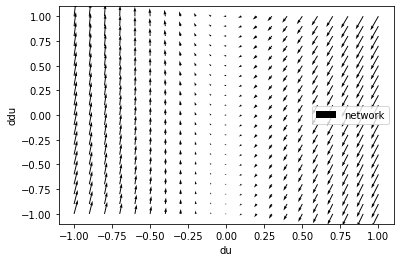

In [75]:
init_net, net = serial(Dense(32),Softplus, Dense(2))

_, params = init_net(key,(2,))

x = jnp.ones((2,))

net(params, x)

def forward_direct(params,u,du):
    x = jnp.asarray((u,du))
    du, duu = net(params,x)
    return du, duu

# for a single scalar input
du, duu = forward_direct(params, 0.0, 0.0)

# for u and du as 2d grid
x,y = jnp.meshgrid(jnp.arange(x_min,x_max+dx, dx),jnp.arange(y_min,y_max+dy, dy))

forward_batched = vmap(forward_direct, (None,0,0),0)
forward_batched = vmap(forward_batched, (None,1,1),1)
du, duu = forward_batched(params,x,y)

fig, ax = plt.subplots()
ax.quiver(x,y,du,ddu, scale_units="xy",angles="xy", label="network")
ax.set_xlabel("du")
ax.set_ylabel("ddu")
ax.legend()